## Rời rạc hóa với Decision Tree 


Rời rạc hóa với Decision Tree (DT) sử dụng DT để xác định các bin tối ưu. Khi DT đưa ra quyết định, nó sẽ chỉ định một quan sát cho một trong n lá cuối. Do đó, bất kỳ DT nào cũng sẽ tạo một đầu ra rời rạc, mà các giá trị là các dự đoán tại mỗi lá trong số n lá của nó.

Làm thế nào để thực hiện rời rạc hóa với với cây?

- 1) Huấn luyện DT có độ sâu giới hạn (2, 3 hoặc 4) bằng cách sử dụng biến mà chúng ta muốn rời rạc hóa và mục tiêu.
- 2) Thay thế các giá trị bằng kết quả trả về của cây.


### Ưu điểm

- Kết quả trả về của DT có quan hệ đơn điệu với mục tiêu.
- Các nút cuối của cây hoặc các bin trong biến rời rạc hóa cho thấy entropy giảm, nghĩa là các quan sát trong từng bin giống nhau hơn so với các quan sát của các bin khác.

### Hạn chế

- Dễ bị over-fitting
- Quan trọng hơn là một số điều chỉnh tham số của cây cần thu được số lượng phân chia tối ưu (ví dụ: độ sâu của cây, số mẫu tối thiểu trong một phân vùng, số phân vùng tối đa và mức tăng thông tin tối thiểu). Điều này có thể tốn thời gian.

## Trong bản mô phỏng này

Chúng ta sẽ học cách triển khai rời rạc hóa với decision tree sử dụng tập dữ liệu Titanic.

### Tập dữ liệu Titanic

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# load các biến dạng số của tập dữ liệu Titanic

data = pd.read_csv('dataset/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Hãy chia thành tập huấn luyện và tập kiểm tra
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

<details><summary> Gợi ý </summary>

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

Các biến age và fare chứa dữ liệu bị khuyết, chúng ta sẽ điền vào bằng cách trích xuất mẫu ngẫu nhiên của biến.

In [4]:
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
def impute_na(data, variable):
    df = data.copy()
    
    # lấy mẫu ngẫu nhiên
    df[variable+'_random'] = df[variable]
    # trích xuất mẫu ngẫu nhiên để điền na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas cần có các index tương tự để hợp nhất các tập dữ liệu
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

<details><summary> Gợi ý </summary>

[sample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

</details>

In [5]:
# thay NA ở cả tập huấn luyện và tập kiểm tra
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

<details><summary> Gợi ý </summary>

Sử dụng hàm ```impute_na()``` ở trên

</details>

### Age

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,40.5,7.7250
686,22.0,7.7250


In [7]:
# ví dụ: xây dựng cây phân loại sử dụng Age để dự đoán Survived (người sống sót)
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:

tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:,1]

X_train.head(10)

,age,fare,Age_tree
501,13.0,19.5000,0.857143
588,4.0,23.0000,0.509091
402,30.0,13.8583,0.398496
1193,40.5,7.7250,0.398496
686,22.0,7.7250,0.398496
971,39.0,7.8792,0.398496
117,30.0,56.9292,0.398496
540,2.0,26.0000,0.509091
294,49.0,110.8833,0.398496
261,35.0,26.2875,0.398496


<details><summary> Gợi ý </summary>

[DecisionTreeClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

</details>

In [8]:
# hãy khám phá xem cây đã tạo bao nhiêu điểm cuối (end-point)
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
X_train['Age_tree'].unique()

array([0.85714286, 0.50909091, 0.39849624, 0.31481481, 0.21428571,
       0.45454545, 0.29411765, 0.09090909])

<details><summary> Gợi ý </summary>

[unique()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html)

</details>

Với cây có depth=2, hãy thực hiện 2 phân chia để tạo 4 bucket, do đó chúng ta thấy 4 xác suất khác nhau trong đầu ra ở trên.

Text(0, 0.5, 'Survived')

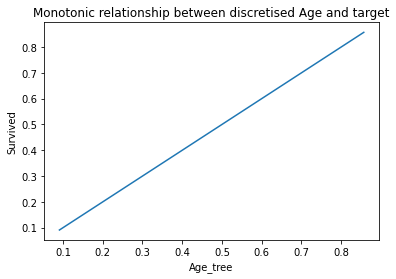

In [9]:
# mối quan hệ đơn điệu với mục tiêu
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<details><summary> Gợi ý </summary>

[concat()](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)

</details>

<AxesSubplot:xlabel='Age_tree'>

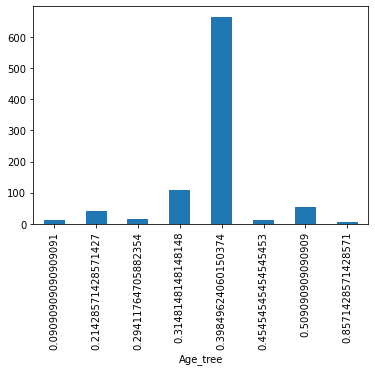

In [10]:
# số hành khách trên mỗi bucket/bin xác suất
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
X_train.groupby(['Age_tree'])['age'].count().plot.bar()

<details><summary> Gợi ý </summary>

[bar()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)

</details>

<AxesSubplot:xlabel='Age_tree'>

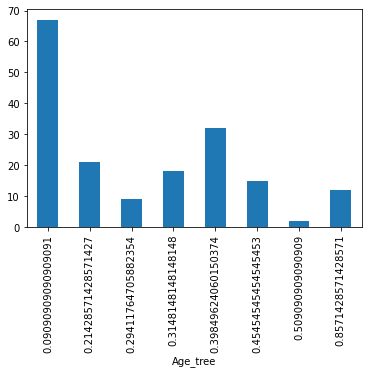

In [11]:
# tuối trung bình trong mỗi bucket từ cây
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
X_train.groupby(['Age_tree'])['age'].median().plot.bar()

<details><summary> Gợi ý </summary>

[bar()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)

</details>

In [12]:
# hãy xem cách cây tạo bucket giới hạn Age
# bằng cách nắm bắt độ tuổi tối lớn nhất và nhỏ nhất ở mỗi bucket xác suất
# chúng ta có ý tưởng về giới hạn bucket
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
pd.concat( [X_train.groupby(['Age_tree'])['age'].min(),
            X_train.groupby(['Age_tree'])['age'].max()], axis=1)

,age,age
Age_tree,,
0.090909,65.0000,74.0
0.214286,21.0000,21.0
0.294118,9.0000,11.5
0.314815,16.0000,20.0
0.398496,22.0000,64.0
0.454545,14.0000,15.0
0.509091,0.1667,8.0
0.857143,12.0000,13.0


<details><summary> Gợi ý </summary>

[concat()](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)

</details>

Do đó, DT tạo ra các bucket: 65-74, 9-44, 45-64, 0.7-8 và 0-16-0.16 với xác suất sống sót tương ứng là .0, .36, .45, .52 và .1.

### Tree visualisation (Trực quan hóa cây)

In [13]:
# hãy tiếp tục và hình dung cây bằng cách lưu mô hình vào một file,
# và mở file trong trong liên kết ở dưới
## Yêu cầu 10:
## VIẾT CODE Ở ĐÂY:
with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# truy cập trang sau và mở file: http://webgraphviz.com

<details><summary> Gợi ý </summary>

[export_graphviz()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)

</details>

In [14]:
# nếu thực hiện như hướng dẫn trong cell trước đó, chúng ta sẽ thấy như sau

# Lưu ảnh cần truy xuất trong server trên ở dạng png sau đó load
# nó vào đây để xử lý mô phỏng

# biểu đồ thể hiện giới hạn của age cả số mẫu ở từng nút và 
# gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)

FileNotFoundError: [Errno 2] No such file or directory: 'tree_visualisation.png'

**Hãy mở rộng kết quả cây sang tập kiểm tra và khám phá mối quan hệ đơn điệu**

Text(0, 0.5, 'Survived')

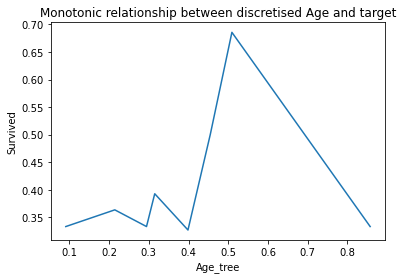

In [15]:
## Yêu cầu 11:
## VIẾT CODE Ở ĐÂY:
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# mối quan hệ đơn điệu với mục tiêu

pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<details><summary> Gợi ý </summary>

[predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

</details>

Chúng ta có thể thấy rằng mối quan hệ đơn điệu không được duy trì trong tập kiểm tra, điều này chỉ ra cây mà chúng ta xây dựng bị quá khớp với tập huấn luyện.

### Xây dựng DT tối ưu

Chúng ta có thể tối ưu hóa một số tham số để có được phân chia bin tốt nhất sử dụng DT.

Hãy tối ưu hóa độ sâu của cây để chứng minh. Nhưng hãy nhớ rằng chúng ta cũng có thể tối ưu hóa các tham số còn lại của DT.

Truy cập [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) để xem có thể tối ưu hóa các tham số nào khác.

In [17]:
# Xây dựng cây có độ sâu khác và tính roc-auc của từng cây
# chọn độ sâu (depth) tạo ra roc-auc tốt nhất

from sklearn.model_selection import KFold


score_ls = []  # lưu roc auc ở đây
score_std_ls = []  # lưu độ lệch chuẩn của roc_auc ở đây

for tree_depth in [1, 2, 3, 4]:

    # gọi mô hình
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # huấn luyện mô hình sử dụng kiểm định chéo 3-fold
    ## Yêu cầu 12:
    ## VIẾT CODE Ở ĐÂY:
    scores = cross_val_score(
        tree_model, X_train['age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    
    # lưu các tham số
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# đưa các tham số vào một dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.481819,0.019323
1,2,0.505185,0.010830
2,3,0.506725,0.004183
3,4,0.521277,0.017416


<details><summary> Gợi ý </summary>

[cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

</details>

Chúng ta thu được roc-auc tốt nhất bằng cách sử dụng độ sâu 2 (cùng giá trị với độ sâu 4 nhưng std nhỏ hơn). Hãy chọn độ sâu là 2 để tiếp tục.

### Biến đổi đặc trưng sử dụng cây

In [18]:
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:, 1]
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:, 1]

<details><summary> Gợi ý </summary>

[DecisionTreeClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

[predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

</details>

Text(0, 0.5, 'Survived')

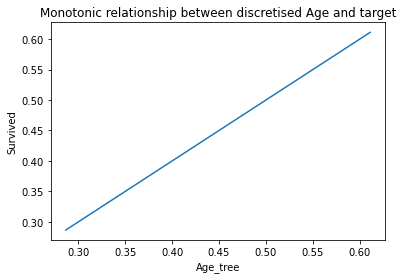

In [19]:
# mối quan hệ đơn điệu với mục tiêu trong tập huấn luyện
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<details><summary> Gợi ý </summary>

[concat()](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)

</details>

Text(0, 0.5, 'Survived')

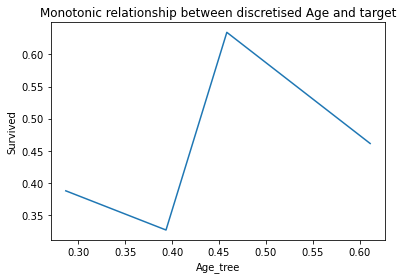

In [20]:
# và trong tập kiểm tra
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# mối quan hệ đơn điệu với mục tiêu
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<details><summary> Gợi ý </summary>

[predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

</details>

Bây giờ mối quan hệ đơn điệu không được duy trì hoàn toàn trong tập kiểm tra. Có lẽ vì có ít mẫu trong các bucket trên:

<AxesSubplot:xlabel='Age_tree'>

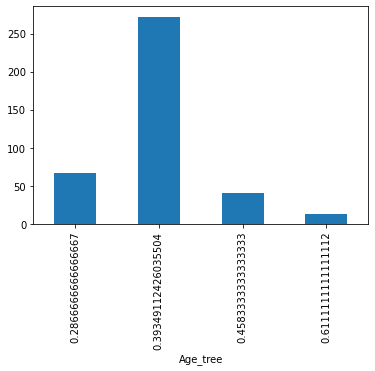

In [21]:
# độ tuổi trung bình trong từng bucket từ cây
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
X_test.groupby(['Age_tree'])['age'].count().plot.bar()

<details><summary> Gợi ý </summary>

[groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

</details>

Chúng ta có thể thử tối ưu hóa thêm DT để xem liệu có thể giữ mối quan hệ đơn điệu hay không. Hoặc trực tiếp kiểm tra chất lượng của mô hình với các đặc trưng được thiết kế này và xem chúng có thêm bất kỳ giá trị nào hay không.

## Rời rạc hóa với Decision Tree sử dụng Feature-Engine


Feature-Engine cho phép chúng ta triển khai rời rạc hóa với DT trên tất cả các biến dạng số một cách dễ dàng, bao gồm việc tìm kiếm trên nhiều tham số của DT để tìm ra tham số tốt nhất.

## Trong bản mô phỏng này

Chúng ta sẽ học cách thực hiện Rời rạc hóa với Decision Tree và Feature-Engine sử dụng tập dữ liệu Titanic.

### Tập dữ liệu Titanic 

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser

In [23]:
# load biến dạng số của tập dữ liệu Titanic

data = pd.read_csv('dataset/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [24]:
# Hãy chia thành tập huấn luyện và tập kiểm tra
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

<details><summary> Gợi ý </summary>

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

Các biến age và fare chứa dữ liệu bị khuyết, chúng ta sẽ điền vào bằng cách trích xuất mẫu ngẫu nhiên của biến.

In [25]:
## Yêu cầu 18:
## VIẾT CODE Ở ĐÂY:
def impute_na(data, variable):
    df = data.copy()

    # lấy mẫu ngẫu nhiên
    df[variable+'_random'] = df[variable]
    
    # trích xuất mẫu ngẫu nhiên để điền na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    
    # pandas cần có các index tương tự để hợp nhất các tập dữ liệu
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

<details><summary> Gợi ý </summary>

[sample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

</details>

In [26]:
# thay NA ở cả tập huấn luyện và tập kiểm tra
## Yêu cầu 19:
## VIẾT CODE Ở ĐÂY:
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

<details><summary> Gợi ý </summary>

Sử dụng hàm ```impute_na()``` ở trên

</details>

In [27]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,40.5,7.7250
686,22.0,7.7250


In [28]:
# thiết lập DT discretiser thể hiện:
# số kiểm định chéo (cv)
# cách đánh giá chất lượng mô hình (scoring)
# các biến mà chúng ta muốn rời rạc hóa (biến)
# liệu nó là mục tiêu cho hồi quy hay phân loại
# và lưới với các tham số mà chúng ta muốn kiểm tra
## Yêu cầu 20:
## VIẾT CODE Ở ĐÂY:
treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

<details><summary> Gợi ý </summary>

[DecisionTreeDiscretiser()](https://feature-engine.readthedocs.io/en/latest/discretisation/DecisionTreeDiscretiser.html)

</details>

In [29]:
# kiểm tra cây cho age
## Yêu cầu 21:
## VIẾT CODE Ở ĐÂY:
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

<details><summary> Gợi ý </summary>

Using ```best_params_```

</details>

In [ ]:
# và chất lượng đạt được trên tập huấn luyện trong khi khớp
treeDisc.scores_dict_['age']

In [ ]:
# và các tham số tốt nhất cho fare 
treeDisc.binner_dict_['fare'].best_params_

In [30]:
# và chất lượng đạt được trên tập huấn luyện trong khi khớp
## Yêu cầu 22:
## VIẾT CODE Ở ĐÂY:
treeDisc.scores_dict_['fare']

0.6888646288209607

<details><summary> Gợi ý </summary>

Sử dụng ```scores_dict_```

</details>

Bằng cách so sánh accuracy của DT cho age và fare, chúng ta có thể suy ra rằng fare là chỉ báo tốt hơn về đầu ra survived.

In [31]:
# hãy biến đổi dữ liệu
## Yêu cầu 23:
## VIẾT CODE Ở ĐÂY:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

<details><summary> Gợi ý </summary>

Using ```transform()```

</details>

In [32]:
# hãy kiểm tra xem chúng ta tìm thấy bao nhiêu bin

train_t['age'].unique()

array([0.61111111, 0.50909091, 0.39849624, 0.31481481, 0.21428571,
       0.29411765, 0.09090909])

Text(0, 0.5, 'Survived')

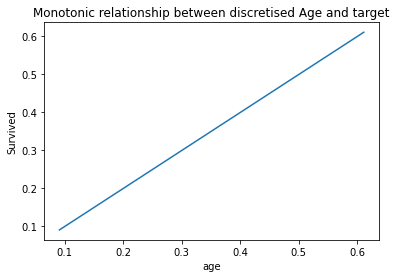

In [33]:
# mối quan hệ đơn điệu với mục tiêu: tập huấn luyện

pd.concat([train_t, y_train], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

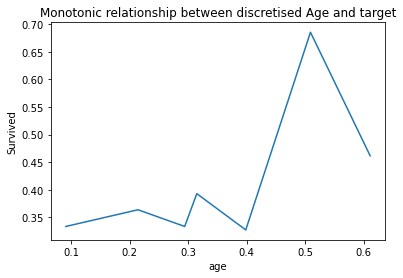

In [34]:
# mối quan hệ đơn điệu với mục tiêu: tập kiểm tra

pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Mối quan hệ đơn điệu giữa bin và mục tiêu không ngạc nhiên. Phải nói rằng chúng ta cần thử khá nhiều với các tham số của cây để tìm ra cây tối ưu nhằm giữ mối quan hệ đơn điệu ở một mức độ nào đó. Nhưng đó là sự đánh đổi, giống như bất cứ điều gì khác trong cuộc sống :)

Text(0, 0.5, 'Survived')

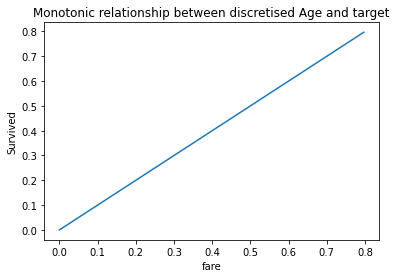

In [35]:
# hãy khám phá mối quan hệ đơn điệu cho fare
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

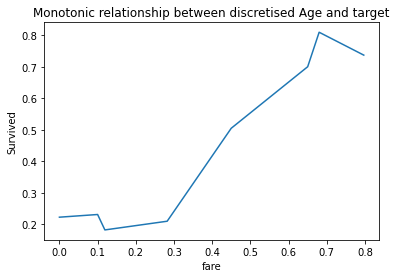

In [36]:
# mối quan hệ đơn điệu với mục tiêu: tập kiểm tra

pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Với fare, mối quan hệ đơn điệu gần như được duy trì hoàn toàn, ngoại trừ ở các biên, điều này cho thấy cây có thể quá khớp với tập huấn luyện.

Text(0, 0.5, 'Number of observations per bin')

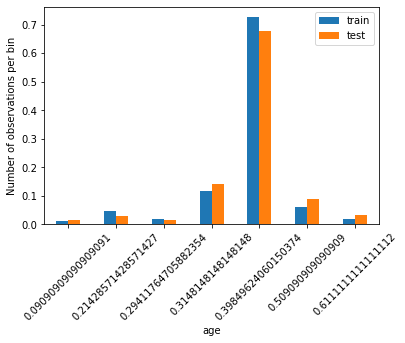

In [37]:
# hãy khám phá xem chúng ta có bao nhiêu quan sát ở mỗi bin

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Hầu hết các quan sát nằm ở bucket giữa, điều này cho thấy biến này không có tính dự đoán cao.

Text(0, 0.5, 'Number of observations per bin')

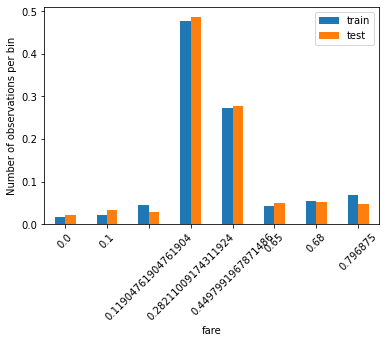

In [38]:
# hãy khám phá xem chúng ta có bao nhiêu quan sát ở mỗi bin

t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Với fare, cây đã sắp xếp các giá trị trong nhiều bucket hơn, do đó tạo ra chênh lệch giá trị tốt hơn (fare khá lệch).